In [1]:
# MIT License

# Copyright (c) [2019] [Jayden Booth]

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Import Libraries
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout, Concatenate
from keras.models import Model
from keras import regularizers
from keras.callbacks import EarlyStopping,Callback,ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
from keras.constraints import max_norm

from scipy import special
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set random seeds
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(3)

In [7]:
# Average Power Normalization
def fixed_power_norm(x,P):
    beta = K.sqrt(K.sum(K.square(x),axis=1))
    return   np.sqrt(P)*x / beta[:,None]

In [8]:
# Set the defining parameters
# n = n_channel complex numbers (so 2n real numbers)
# k = log2(M), where M is the number of messages to encode
# EbNo is the energy per bit to noise power density

# Encoder Parameters
M = 16
k = np.log2(M)
n_channel = 1
R = k/n_channel
print('number of symbols:',M)


number of symbols: 16


In [9]:
def set_up_train_nn(P):
    N=16000
    EbNo_train = 5.01187
    label = np.random.randint(M,size=N)
    
    # creating one hot encoded vectors
    data = []
    for i in label:
        temp = np.zeros(M)
        temp[i] = 1
        data.append(temp)
        # checking data shape
    data = np.array(data)
    print (data.shape)
    
    es = EarlyStopping(monitor='val_loss',patience=5, verbose=1)
    
    # Defined Autoencoder
    input_signal = Input(shape=(M,))
    encoded = Dense(M, activation='relu')(input_signal)
    encoded2 = Dense(2*n_channel, activation='linear')(encoded)

    # Normalize Power
    encoded3 = Lambda(lambda x: fixed_power_norm(x,P))(encoded2)
    
    #Add antenna noise
    encoded5 = Lambda(lambda x: x+K.random_normal_variable((4*4096,2), 0,np.sqrt(1/(2*R*EbNo_train)))[0:tf.shape(x)[0],:])(encoded3)

    # Reciever Layer
    decoded = Dense(M, activation='relu')(encoded5)
    decoded1 = Dense(M, activation='softmax')(decoded)
    autoencoder = Model(input_signal, decoded1)

    adam = Adam(lr=0.01)
    epochs=70
    autoencoder.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])
    
    # traning auto encoder
    history = autoencoder.fit(data, data,epochs=epochs,batch_size=2048,callbacks=[es],validation_split=0.3)
    
    # list all data in history
    print(history.history.keys())
    
    results = autoencoder.evaluate(data, data, batch_size=2048)
    print('test loss, test acc:', results)

    
    # making encoder from full autoencoder
    encoder = Model(input_signal, encoded3)
    
    
    scatter_plot = []
    for i in range(0,M):
        temp = np.zeros(M)
        temp[i] = 1
        scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
    scatter_plot = np.array(scatter_plot)
    print (scatter_plot.shape)
    
    # ploting constellation diagram
    
    scatter_plot = scatter_plot.reshape(M,2,1)

    plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
    #plt.axis((-2,2,-2,2))
    plt.grid()
    #plt.title('Splitting Receiver: rho = '+str(rho)+' P = '+str(P))
    plt.xlabel('I Axis')
    plt.ylabel('Q Axis')
    plt.show()
    p_av = np.sum(np.square(scatter_plot),axis=1)
    print(sum(p_av)/16)
    
    return autoencoder

(16000, 16)
Train on 11200 samples, validate on 4800 samples
Epoch 1/70
11200/11200 [==============================] - 1s 67us/step - loss: 2.6449 - acc: 0.1918 - val_loss: 2.4657 - val_acc: 0.2498
Epoch 2/70
11200/11200 [==============================] - 0s 3us/step - loss: 2.3686 - acc: 0.2913 - val_loss: 2.2327 - val_acc: 0.3060
Epoch 3/70
11200/11200 [==============================] - 0s 4us/step - loss: 2.1323 - acc: 0.3217 - val_loss: 1.9848 - val_acc: 0.3252
Epoch 4/70
11200/11200 [==============================] - 0s 3us/step - loss: 1.8842 - acc: 0.3719 - val_loss: 1.7515 - val_acc: 0.3937
Epoch 5/70
11200/11200 [==============================] - 0s 3us/step - loss: 1.6634 - acc: 0.4313 - val_loss: 1.5496 - val_acc: 0.4542
Epoch 6/70
11200/11200 [==============================] - 0s 3us/step - loss: 1.4777 - acc: 0.5143 - val_loss: 1.3839 - val_acc: 0.5758
Epoch 7/70
11200/11200 [==============================] - 0s 3us/step - loss: 1.3267 - acc: 0.6254 - val_loss: 1.2554 - va

11200/11200 [==============================] - 0s 3us/step - loss: 0.2549 - acc: 0.9112 - val_loss: 0.2549 - val_acc: 0.9173
Epoch 61/70
11200/11200 [==============================] - 0s 4us/step - loss: 0.2525 - acc: 0.9114 - val_loss: 0.2497 - val_acc: 0.9163
Epoch 62/70
11200/11200 [==============================] - 0s 4us/step - loss: 0.2550 - acc: 0.9088 - val_loss: 0.2516 - val_acc: 0.9131
Epoch 63/70
11200/11200 [==============================] - 0s 3us/step - loss: 0.2506 - acc: 0.9122 - val_loss: 0.2506 - val_acc: 0.9119
Epoch 64/70
11200/11200 [==============================] - 0s 4us/step - loss: 0.2578 - acc: 0.9100 - val_loss: 0.2543 - val_acc: 0.9100
Epoch 65/70
11200/11200 [==============================] - 0s 4us/step - loss: 0.2523 - acc: 0.9088 - val_loss: 0.2435 - val_acc: 0.9163
Epoch 66/70
11200/11200 [==============================] - 0s 3us/step - loss: 0.2538 - acc: 0.9067 - val_loss: 0.2498 - val_acc: 0.9129
Epoch 67/70
11200/11200 [============================

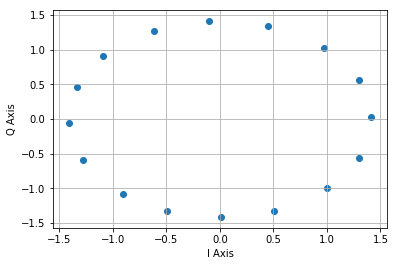

[2.]


In [11]:
# Calculating SER from -4dB to 14dB SNR
autoencoder = set_up_train_nn(2)